# 0. Problem statement

As a **quantitative analyst**, I am interested in determining whether the following trading strategy using the RSI oscillator on S&P500 stocks can yield positive risk-adjusted returns for our portfolio:
- Buy the stock when the RSI oscillator hits 30. 
- Sell the stock either when the RSI oscillator hits 70 or in half a quarter (45 days), whichever comes first. 

# I. Approach

- $H_0$: The risk adjusted return for our portfolio is less than or equal to 0%.
- $H_a$: The risk adjusted return for our portfolio is greater than 0%.

We have 500 stocks to choose from and our dataset of S&P500 stocks has each company's GICS sector as well. So, we can use stratified random sampling to select a "mini-S&P 500 portfolio" on each run and apply our trading strategy to evaluate our monthly returns. From a quick google search, we see that most of the companies that are part of the S&P500 index today have been publicly listed for at least 3 years (which can be our time period for back-testing). However, there are some exceptions (found from an initial run of downloading the data). This is elabored upon later in this notebook, but the bottom-line is that we will be removing those tickers from our analysis.

Here are some rules we can set for ourselves:
- Every time one of our 30 stocks' RSI value hits 30, we will invest $\$1000$. 
- Since we can't assume we have an infinite amount of cash on us, we will start our 3 year period with $\$30000$. 
- We are expected to liquidate all our positions by EOM, we will know what our total cash balance is at the end.
- If the cash balance at the start of the month is less than $\$30,000$, then we will not be allowed to invest in all 30 companies if we wanted to (i.e. we cannot purchase stock on margin). 
- If the cash balance at the start of the month is greater than $\$30000$, then we will be allowed to invest a greater dollar amount per company; so, if our cash balance started at $\$33000$, then we will be allowed to invest $\$33,000/30 = \$1100$ per company. 

# II. Imports

In [1]:
cd ../

/home/murali/personal_projects/stock-price-forecasts


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas_datareader.data as reader
import datetime as dt
from datetime import timedelta
from typing import Iterable, Union
import itertools
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px
import logging
import scipy

In [35]:
from src.backtesting import Backtesting

# III. S&P500 data exploration

In [4]:
sp500_df = pd.read_csv("eda/data/sp_500_stocks.csv")

In [5]:
sp500_df.head()

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,865,693,839,600",0.50%,29.04,7.57,40.60
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$2,329,276,399,180",0.76%,33.22,12.60,14.78
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,916,810,491,712",0.00%,11.89,7.44,3.59
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,916,810,491,712",0.00%,11.27,7.44,3.41
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$1,719,797,425,362",0.00%,51.65,3.66,12.46


In [6]:
# Ensuring that our tickers are unique
sp500_df["Symbol"].is_unique

True

In [7]:
def tickers_to_remove(df: pd.DataFrame, ticker_list: Iterable) -> pd.DataFrame:
    mask = True
    
    for ticker in ticker_list:
        mask &= (df["Symbol"] != ticker)
    
    return df.loc[mask].reset_index(drop=True)

In [8]:
def replace_ticker_names(df: pd.DataFrame, old_to_new_ticker_mapping: dict) -> pd.DataFrame:
    for old, new in old_to_new_ticker_mapping.items():
        df.loc[df["Symbol"] == old, "Symbol"] = new
    
    return sp500_df

The tickers below are of stocks that have IPO'd much later into our 3 year window and would limit the time we will be back-testing our data for.

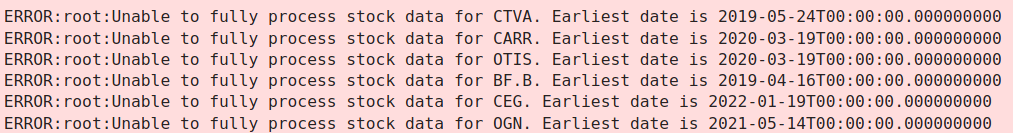

Removing the tickers in this list as well as "GOOGL" and "UAA". Removing "Alphabet Inc Class A" and "Under Armour Class A" shares, which are both just common shares with voting rights. As far as trends are concerned in the stock price movement for that company, it will be the same for both class A and class C shares. So, removing the former to have just one ticker per company in this dataset. 

In [9]:
sp500_df = tickers_to_remove(sp500_df, ["GOOGL", "UAA", "CTVA", "CARR", "OTIS", "BF.B", "CEG", "OGN", "AMCR"])

In [10]:
old_to_new_ticker_mapping = {
    "BRK.B": "BRK-B"
}

sp500_df = replace_ticker_names(sp500_df, old_to_new_ticker_mapping)

In [11]:
sector_mapping = {
    "Information Technology": "IT",
    "Information technology": "IT", 
    "Industrials": "ID",
    "Financials": "F",
    "Health Care": "HC",
    "Consumer Discretionary": "CD",
    "Consumer Staples": "CS",
    "Utilities": "U",
    "Real Estate": "RE",
    "Materials": "M",
    "Communication Services": "CM",
    "Energy": "E"
}

sp500_df["sector"] = sp500_df["GICS Sector"].replace(sector_mapping)

In [12]:
sp500_df["sector"].value_counts()

IT    75
ID    70
F     67
HC    64
CD    59
CS    31
RE    29
U     28
CM    26
M     26
E     21
Name: sector, dtype: int64

# IV. Calculating $\beta$ and RSI:

We can use the following formula to compute the $\beta$ for each stock over our back-testing period:
$$\beta_i = \frac{Cov(R_i, R_m)}{\sigma_m^2}$$
where:
- $R_i$ is the return of asset $i$.
- $R_m$ is the return on our chosen market index: S&P 500.
- $\sigma_m$ is the standard deviation of returns on the chosen market index.

In [13]:
def calculate_daily_returns(series_of_prices: pd.Series) -> pd.Series:
    return np.log(series_of_prices/series_of_prices.shift())

In [14]:
def calculate_beta(asset_returns: pd.Series, index_returns: pd.Series, index_returns_var: float) -> pd.Series:
    cov_matrix = np.cov(asset_returns, sp500_returns)
    return cov_matrix[0,1]/index_returns_var

We can calculate RSI on a standard 14-d window using the following formula:
$$RSI=100-\frac{100}{1+RS}$$
where:
- RS is the relative strength indicator and is given by $RS = \sum_{d=1}^{14} \frac{total~returns~up}{total~returns~down}$

In [15]:
def calculate_rsi(df: pd.DataFrame) -> pd.DataFrame:
    mask = df["daily_return"] >= 0
    
    df["is_up"] = (df["daily_return"] >= 0).replace({True: 1, False: 0})
    df["is_down"] = (df["daily_return"] < 0).replace({True: 1, False: 0})
    df["up_return"] = df["is_up"]*df["daily_return"]
    df["down_return"] = df["is_down"]*abs(df["daily_return"])

    df["RSI"] = 100 - 100/(1+df["up_return"].rolling(14).sum()/df["down_return"].rolling(14).sum())
    
    df = df.drop(columns=["is_up", "is_down", "up_return", "down_return"])
    
    return df

# V. Loading, pre-processing, and locally storing our datasets 

It would be a good idea for us to store our datasets locally for the following reasons:
1. We don't have to run the API calls every time we wish to load the same data
2. These datasets can be useful for other analyses (outside this notebook) as well.

**So, if you have not run the code below, please do.**

In [16]:
common_path = "eda/data/sp500/"
earliest_data_fetch_date = dt.datetime(2019, 3, 1).date()
start_date = dt.datetime(2019, 4, 15).date()
end_date = dt.datetime(2022, 3, 30).date()
index_ticker = ("^GSPC")    # S&P 500

In [17]:
def get_stock_data(ticker: str, start_date: dt, end_date: dt) -> pd.DataFrame:
    return reader.get_data_yahoo(ticker, earliest_data_fetch_date, end_date)

In [18]:
def write_df_to_local_directory(path: str, df: pd.DataFrame) -> None:
    df.to_parquet(path)

In [19]:
def preprocess_input_df(df: pd.DataFrame, earliest_start_date: dt) -> pd.DataFrame:   
    df = df.reset_index()
    df = df.rename(columns={
        "Date": "date", 
        "High": "high", 
        "Low": "low", 
        "Open": "open", 
        "Close": "close", 
        "Adj Close": "closing_price"
    })
    df = df.drop_duplicates(subset=["date"])
    
    df["daily_return"] = calculate_daily_returns(df["closing_price"])
    
    df = calculate_rsi(df)
    
    return df.loc[df["date"] > pd.Timestamp(start_date)]

In [33]:
def get_10y_treasury_yield_data(index_df: pd.DataFrame, start_date: dt) -> pd.DataFrame:
    path = "eda/data/10-year-treasury-yield.csv"
    
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.rename(columns={" value": "yield"}).set_index("date")
    df = df.reindex(index_df.set_index("date").index)
    
    return df.fillna(method="ffill")

In [22]:
# Read and store index data
# sp500 = get_stock_data(index_ticker, start_date, end_date)
# sp500 = preprocess_input_df(sp500, earliest_data_fetch_date)
# path = common_path + "sp500.parquet"
# write_df_to_local_directory(path, sp500)

In [23]:
sp500 = pd.read_parquet(common_path + "sp500.parquet")
sp500_prices = sp500.set_index("date")["closing_price"]
sp500_returns_variance = np.var(sp500.set_index("date")["daily_return"])

In [24]:
# stock_to_beta = {"ticker": [], "beta": []}

# for ticker in sp500_df["Symbol"]:
#     try:
#         df = get_stock_data(ticker, earliest_data_fetch_date, end_date)
#         df = preprocess_input_df(df, earliest_data_fetch_date)
#         stock_to_beta["beta"] += [calculate_beta(df["daily_return"], sp500_returns, sp500_returns_variance)]
#         stock_to_beta["ticker"] += [ticker]
#         path_ticker = common_path + f"{ticker}.parquet"
#         if all(~df["RSI"].isnull()):
#             write_df_to_local_directory(path_ticker, df)
#         else:
#             logging.warning(f"Stock data for {ticker} had null RSI values. So, we can't use this for analysis.")
#     except:
#         earliest_date = df["date"].values[0]
#         logging.error(f"Unable to fully process stock data for {ticker}. Earliest date is {earliest_date}")

# stock_to_beta = pd.DataFrame(stock_to_beta)
# path_beta = common_path + "stock_to_beta.parquet"
# write_df_to_local_directory(path_beta, stock_to_beta)

# VI. Choosing our sample on each iteration

In [25]:
sp500_df["sector"].value_counts()/len(sp500_df)*30

IT    4.536290
ID    4.233871
F     4.052419
HC    3.870968
CD    3.568548
CS    1.875000
RE    1.754032
U     1.693548
CM    1.572581
M     1.572581
E     1.270161
Name: sector, dtype: float64

Clearly, we can't get an even number of stocks per category, so let us use the normalised values above to determine a fixed number of companies to pick per category:

In [26]:
num_stocks_per_sector = {
    "IT": 4,
    "ID": 4,
    "F": 4,
    "HC": 4,
    "CD": 3,
    "CS": 2,
    "RE": 2,
    "U": 2,
    "M": 2,
    "CM": 2,
    "E": 1
}

In [27]:
tickers_per_sector = {}

for sector in num_stocks_per_sector.keys():
    mask = sp500_df["sector"] == sector
    tickers_per_sector[sector] = np.array(sorted(sp500_df.loc[mask]["Symbol"]))

In [28]:
def select_sample_for_backtesting(num_stocks_per_sector: dict, tickers_per_sector: dict) -> Iterable:
    sample_tickers = []
    
    for sector in num_stocks_per_sector.keys():
        tickers_in_sector = tickers_per_sector[sector]
        num_stocks = num_stocks_per_sector[sector]
        
        random_indices = np.random.randint(0, len(tickers_in_sector), num_stocks, dtype=int)
        
        sample_tickers += list(tickers_in_sector[random_indices])
    
    return sample_tickers

# VII. Iterate through our trading strategy

In [29]:
def create_compiled_df(
    df_with_date: pd.DataFrame, stock_sample: Iterable, common_path: str) -> pd.DataFrame:
    
    df = pd.DataFrame(sp500["date"]).reset_index(drop=True)
    
    for ticker in stock_sample:
        path = common_path + f"{ticker}.parquet"
        ticker_df = pd.read_parquet(path, columns=["closing_price", "RSI", "daily_return"]).reset_index(drop=True)
        df[f"closing_price_{ticker}"] = ticker_df["closing_price"]
        df[f"RSI_{ticker}"] = ticker_df["RSI"]
    
    df = df.reset_index(drop=True)
    
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    
    eom_indices = df.reset_index().groupby(["month", "year"]).nth(-1)["index"]
    df["is_eom"] = df.index.isin(eom_indices)

    return df

In [30]:
def create_is_buy_df(df_with_date: pd.DataFrame, compiled_df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(sp500["date"]).reset_index(drop=True)
    
    for ticker in stock_sample:
        path = common_path + f"{ticker}.parquet"
        rsi_col = compiled_df[f"RSI_{ticker}"]
        mask = (rsi_col <= 30)
        mask &= (rsi_col.shift() > 30)
        df[f"is_buy_{ticker}"] = mask
    
    return df.reset_index(drop=True)

In [31]:
def create_is_sell_df(df_with_date: pd.DataFrame, compiled_df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(df_with_date["date"]).reset_index(drop=True)
    
    for ticker in stock_sample:
        path = common_path + f"{ticker}.parquet"
        rsi_col = compiled_df[f"RSI_{ticker}"]
        mask = (rsi_col >= 70)
        mask &= (rsi_col.shift() < 70)
        df[f"is_sell_{ticker}"] = mask
    
    return df.reset_index(drop=True)

In [36]:
# Trial for one iteration
initial_cash_balance = 30000
stock_sample = select_sample_for_backtesting(num_stocks_per_sector, tickers_per_sector)
stock_to_beta_df = pd.read_parquet(common_path + "stock_to_beta.parquet").set_index("ticker")
compiled_df = create_compiled_df(sp500, stock_sample, common_path)
is_buy_df = create_is_buy_df(sp500, compiled_df)
is_sell_df = create_is_sell_df(sp500, compiled_df)
ten_yr_yield = get_10y_treasury_yield_data(sp500, start_date)

b = Backtesting(initial_cash_balance, end_date, compiled_df, ten_yr_yield, stock_to_beta_df, sp500_prices)
transactions_df, capm_df = b.implement_trading_strategy(is_buy_df, is_sell_df, "rsi")

In [37]:
# for iteration in range(0, 200):
#     initial_cash_balance = 30000
#     stock_sample = select_sample_for_backtesting(num_stocks_per_sector, tickers_per_sector)
#     stock_to_beta_df = pd.read_parquet(common_path + "stock_to_beta.parquet").set_index("ticker")
#     compiled_df = create_compiled_df(sp500, stock_sample, common_path)
#     is_buy_df = create_is_buy_df(sp500, compiled_df)
#     is_sell_df = create_is_sell_df(sp500, compiled_df)
#     ten_yr_yield = get_10y_treasury_yield_data(sp500, start_date)
#     transactions_df, capm_df = implement_trading_strategy(initial_cash_balance, stock_sample, compiled_df, is_buy_df, is_sell_df, stock_to_beta_df, sp500_prices, ten_yr_yield)
    
#     results_path = "data/trading_strategy_rsi/"
#     path_transactions_df = results_path + f"transactions/transactions_{iteration}.parquet"
#     path_capm_df = results_path + f"capm/capm_{iteration}.parquet"
    
#     write_df_to_local_directory(path_transactions_df, transactions_df)
#     write_df_to_local_directory(path_capm_df, capm_df)

# VIII. Analyse the results

**Analysis we can do with the data we have (for an initial cash balance of $30k):**
1. Hypothesis test on our samples to address our main objective for the problem we posed in this notebook.
    - Since our sample size is equal to 200 > 30, we can consider our sample statistically large enough.
    - This means that we can use a z-test for our hypothesis testing.
    - Since the population variance is unknown, we'll use the sample standard deviation for estimating the standard error of the mean (risk adjusted return). 
2. Distribution of the mean risk adjusted return for the 200 portfolios created in our iterations.
3. Distribution of cash profits for the 200 portfolios created in our iterations.
4. Cash profits vs. risk adjusted returns

In [40]:
results_path = "eda/data/trading_strategy_rsi/"
initial_cash_balance = 30000
cash_profits = []
mean_risk_adjusted_ri = []

for iteration in range(0, 200):
    transactions_df = pd.read_parquet(results_path + f"transactions/transactions_{iteration}.parquet")
    capm_df = pd.read_parquet(results_path + f"capm/capm_{iteration}.parquet")
    cash_profits += [transactions_df.iloc[len(transactions_df)-1]["cash_balance"] - initial_cash_balance]
    mean_risk_adjusted_ri += [capm_df["risk_adjusted_ri"].mean()*100]

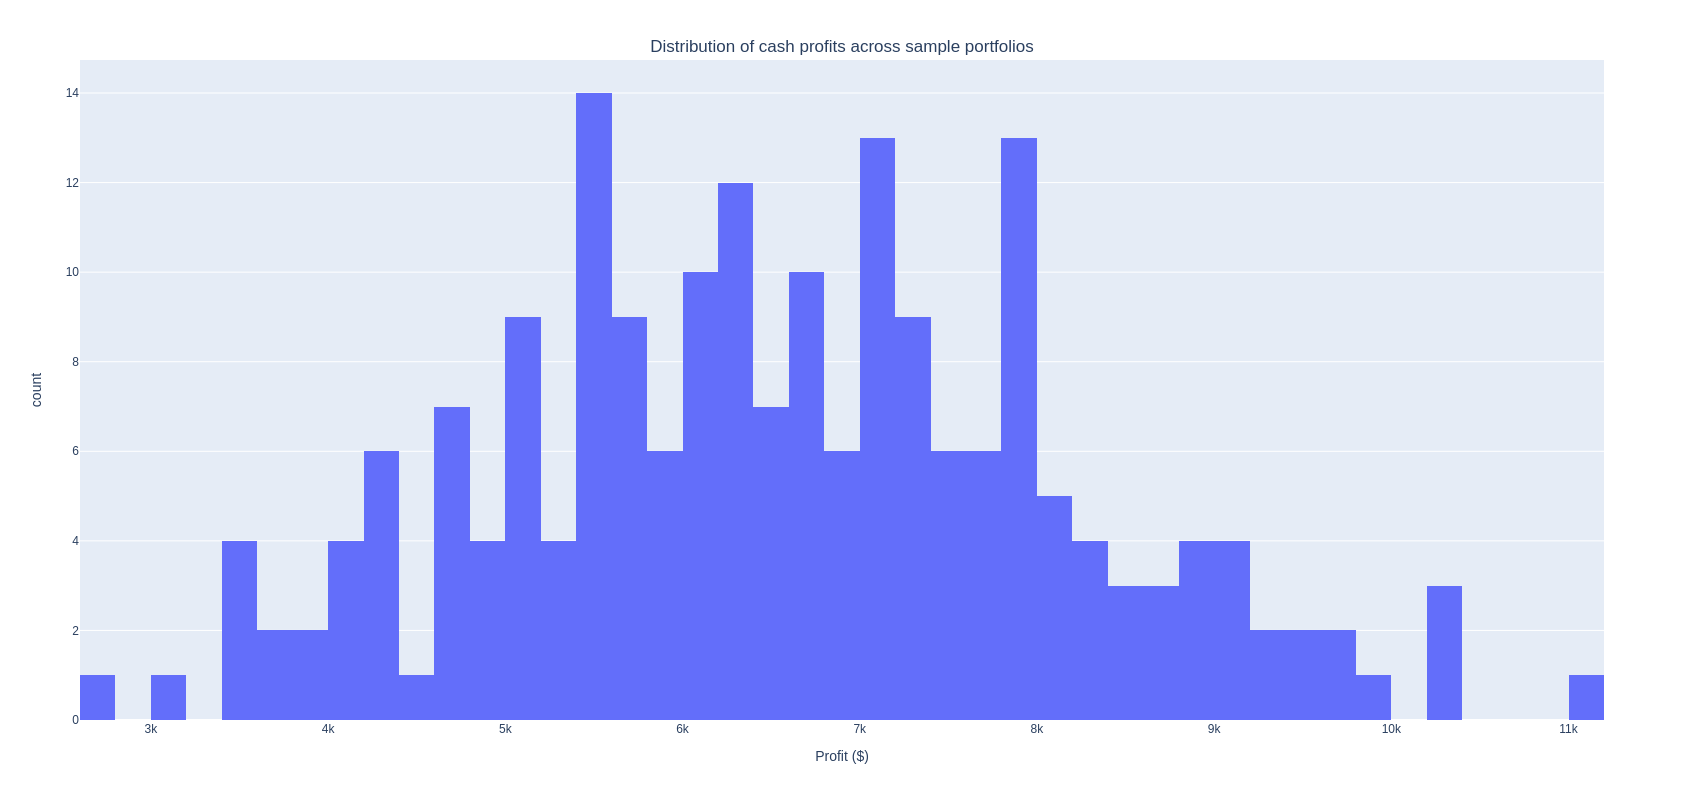

In [41]:
fig = px.histogram(cash_profits, nbins=50)
fig.update_xaxes(title_text="Profit ($)")
fig.update_layout(title_text=f"Distribution of cash profits across sample portfolios", 
                  title_x=0.5,
                  title_y=0.95,
                  height=800,
                  showlegend=False
                 )
fig.show()

**We make an average of $7000 in cash profits over 3 years. On a 30k investment. This averages out to an annual return of approximately 8% between April 2019 and March 2022. The S&P500 has historically made a 10.5% annualised return according to Investopedia. In addition, the annual returns over the last 3 years averaged over 20%!**

**What could this mean for our risk-adjusted returns? Is it below zero?**

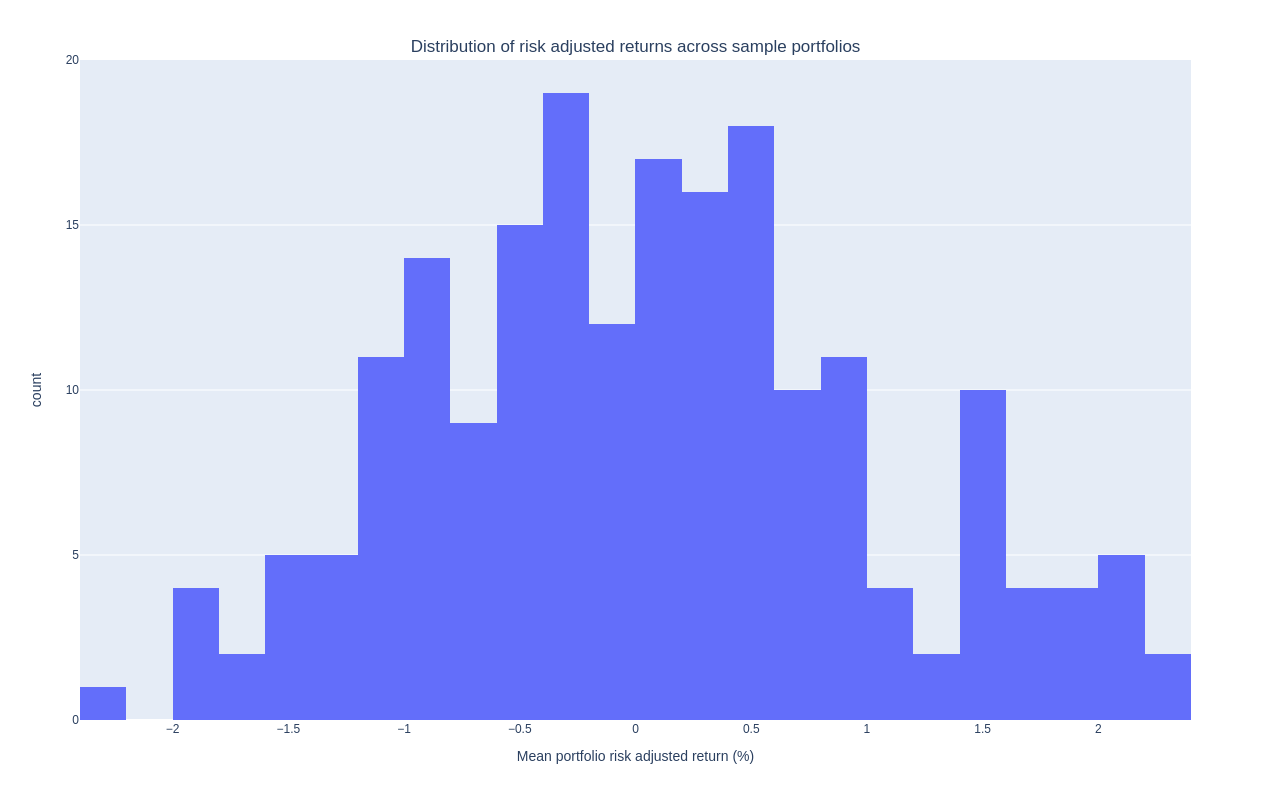

In [42]:
fig = px.histogram(mean_risk_adjusted_ri, nbins=40)
fig.update_xaxes(title_text="Mean portfolio risk adjusted return (%)")
fig.update_layout(title_text=f"Distribution of risk adjusted returns across sample portfolios", 
                  title_x=0.5,
                  title_y=0.95,
                  height=800,
                  showlegend=False
                 )
fig.show()

**The risk adjusted returns have a mean of around zero, which seems to side with our initial hypothesis. The most probable reasons for the lower average cash returns is because (1) our algorithm ensures that every stock in the SP500 has an equal chance of being selected in the sample portfolio of each iteration and (2) our trading strategy invests an equal amount in every stock of the sample portfolio (indicating equal weighting). The S&P500 index, on the other hand, uses a free-float market cap weighting method, which means the larger large-cap stocks get higher weightage than the smaller ones. Large-cap tech stocks like FAANG performed extremely well in 2021, which definitely pushed the index performance up.**

**In summary, it is still up to our hypothesis test to evaluate whether we can make positive risk-adjusted returns or not.**

In [43]:
alpha = 0.05
n = len(mean_risk_adjusted_ri)
u0 = 0
x_bar = np.mean(mean_risk_adjusted_ri)
std_error_of_sample = np.std(mean_risk_adjusted_ri)/np.sqrt(n)

z_statistic = (x_bar - u0)/(std_error_of_sample)
p_value = scipy.stats.norm.sf(abs(z_statistic))

print(f"Our mean risk adjusted return from {n} portfolios is {x_bar}.")
print(f"The z-statistic is equal to {np.round(z_statistic, 2)}, which corresponds to a p-value of {np.round(p_value, 2)}.")

Our mean risk adjusted return from 200 portfolios is 0.052198991761892424.
The z-statistic is equal to 0.76, which corresponds to a p-value of 0.22.


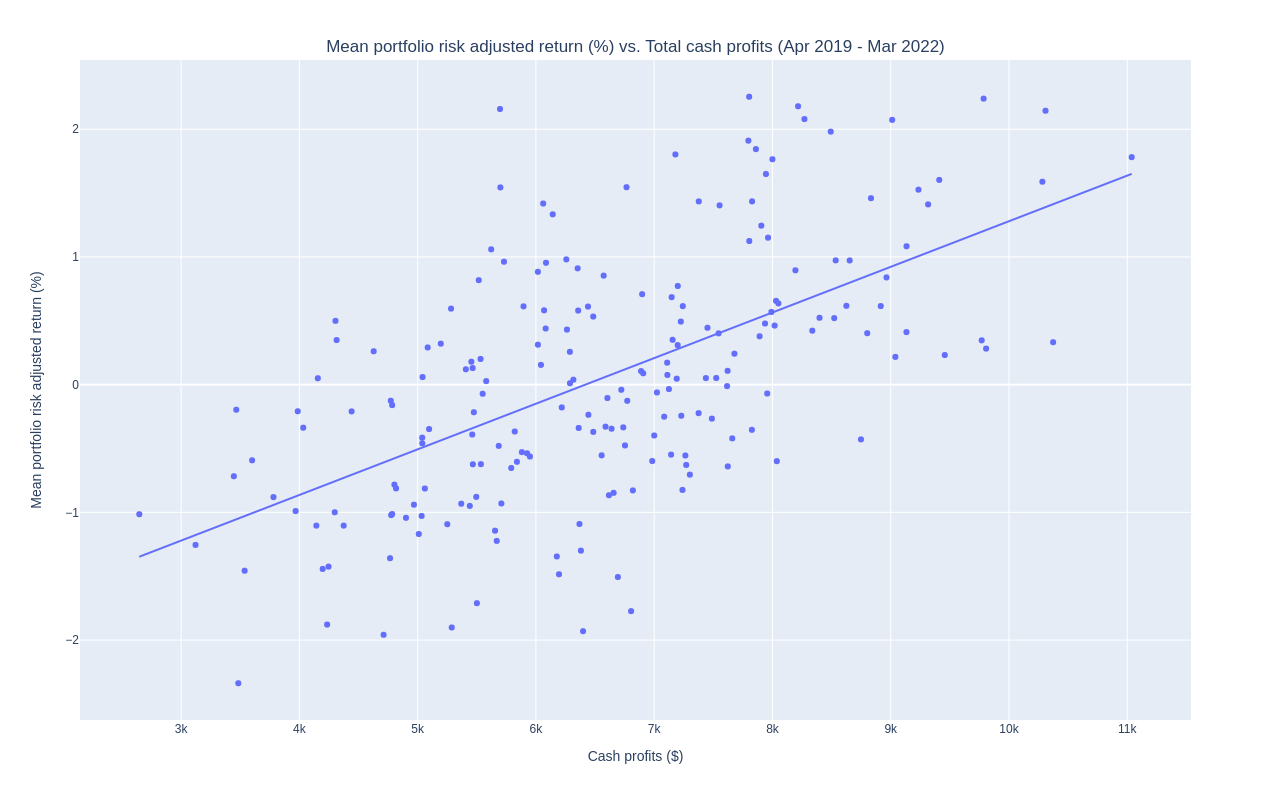

In [44]:
fig = px.scatter(x=cash_profits, y=mean_risk_adjusted_ri, trendline="ols")
fig.update_yaxes(title_text="Mean portfolio risk adjusted return (%)")
fig.update_xaxes(title_text="Cash profits ($)")
fig.update_layout(title_text=f"Mean portfolio risk adjusted return (%) vs. Total cash profits (Apr 2019 - Mar 2022)", 
                  title_x=0.5,
                  title_y=0.95,
                  height=800,
                  showlegend=False
                 )
fig.show()

In [45]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     105.7
Date:                Tue, 05 Apr 2022   Prob (F-statistic):           3.90e-20
Time:                        00:52:48   Log-Likelihood:                -234.21
No. Observations:                 200   AIC:                             472.4
Df Residuals:                     198   BIC:                             479.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2928      0.235     -9.766      0.000      -2.756      -1.830
x1             0.0004   3.48e-05     10.279      0.000       0.000       0.000
==============================================================================
Omnibus:                        1.878   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.955
Skew:                           0.220   Prob(JB):                        0.376
Kurtosis:                       2.799   Cond. No.                     2.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# IX. Conclusions

1. While our mean risk adjusted returns is greater than zero, our p-value > level of significance = 0.05. So, we cannot reject our null hypothesis. This means that we **cannot** statistically prove that our trading strategy will result in positive risk-adjusted returns (given the constraints we used in our testing + the assumptions we made).

2. We see that ash profits and risk adjusted returns on the portfolio generally move in the same direction, but they do not have a strong linear correlation (R2=0.348). This makes a lot of sense, because of the difference between "absolute returns" and "risk-adjusted returns": we can always invest in a risky asset and make a lot of profit, but we may not have achieved as high a return on that risky asset as expected.

# X. Next steps

It is a positive that our mean risk adjusted return on the 200 sample portfolios is greater than zero. This certainly means that we are on the right track and that it is possible for us to refine this basic strategy to come up with one that can generate positive risk-adjusted returns. 

Well... what is lacking in this strategy? Let me use the example below to illustrate one of the possible edge cases:
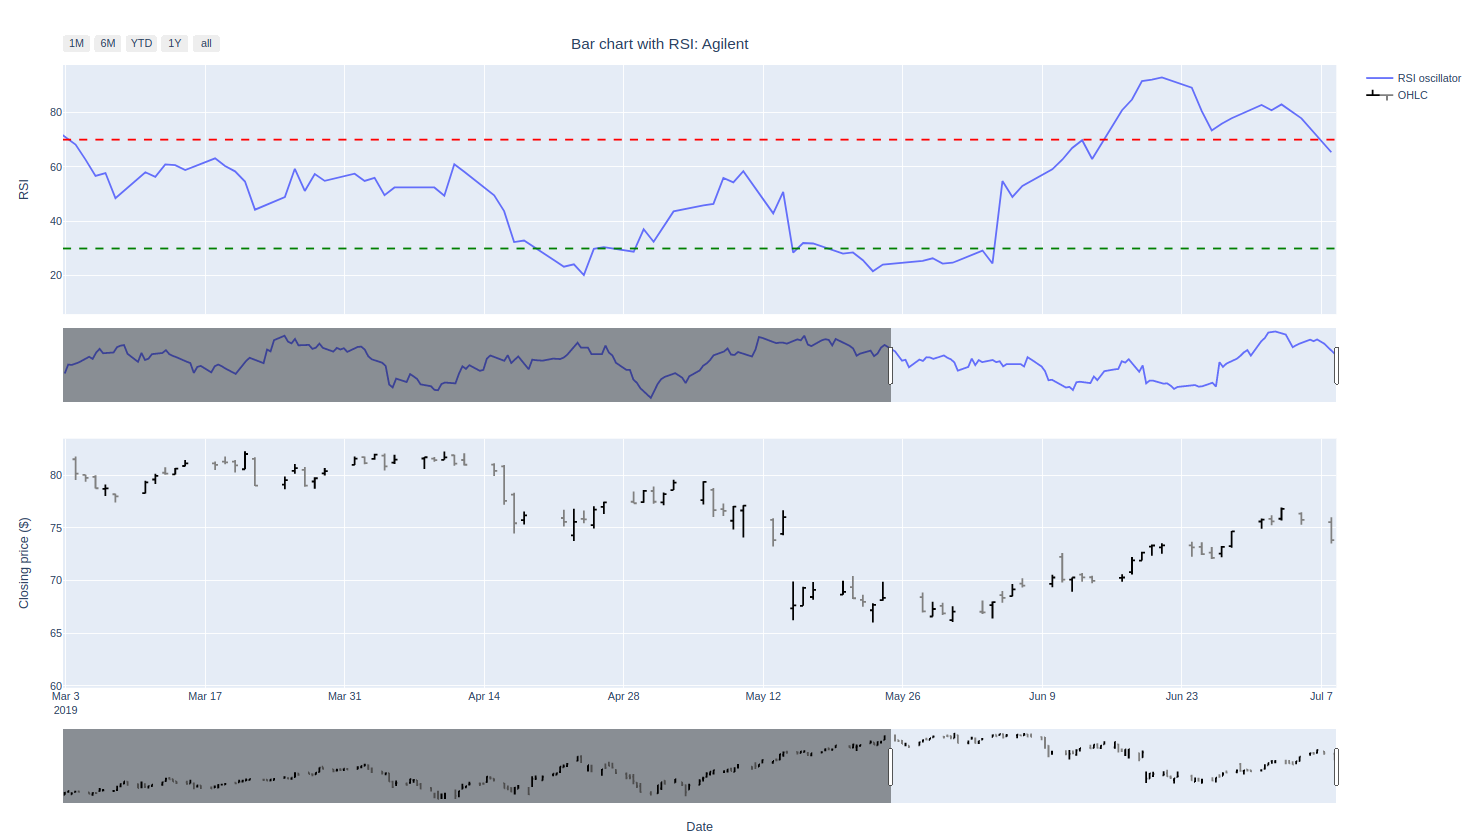

The chart above is for Agilent technologies from March 3, 2019 to July 7, 2019. One of the trades our algorithm would have placed would have been a "buy" at 75 on April 22, when Agilent's RSI went < 30. Using technical analysis alone, this may have looked like an excellent buy (because we may be thinking of this as a dip). However, our algorithm missed out on the fact that this was not a dip but just the beginning of a downfall. In less than a month, the stock price fell down 13% to 65.

Our strategy would have sold the stock when the price hit a RSI = 70 on June 17, but this was signalling that the stock was over-bought on a different scale of price oscillation. A stock that was considered oversold by our algorithm at 75 turned into a one that would be considered overbought at 70. This shows that our trading algorithm relying purely on the RSI momentum oscillator fails to recognise the change in resistance and support levels when a stock falls below its previous support. If we are able to account for this in our trading strategy, we can expect to have better performance relative to our current strategy.